# Imports

In [1]:
import math

from IPython.display import HTML
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import scipy.stats as stats
import pickle

import os
os.chdir("..")
from PIL import Image

import tools.dataset_tools as dataset_tools
from tools.frame_pb2 import Frame
import tools.plot_tools as plot_tools

from tools.simulators import CarSimulator
import tools.plot_tools as plot_tools
%matplotlib inline

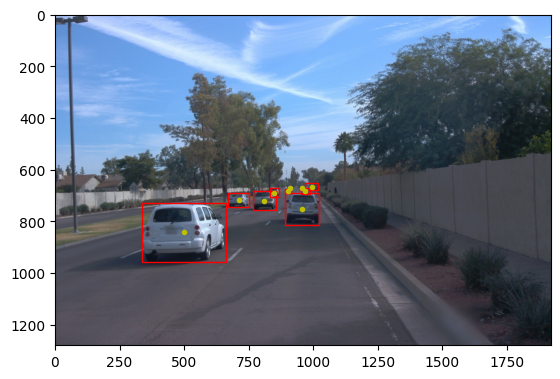

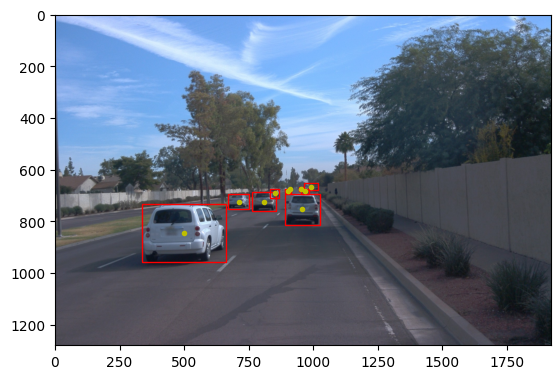

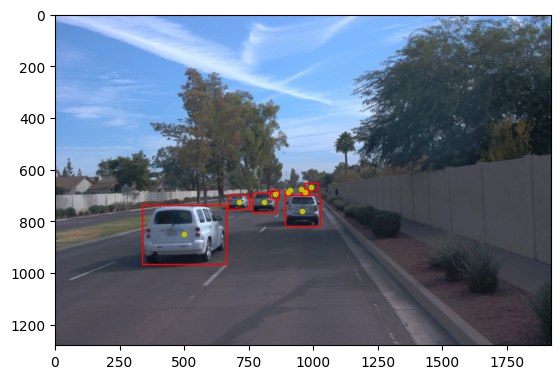

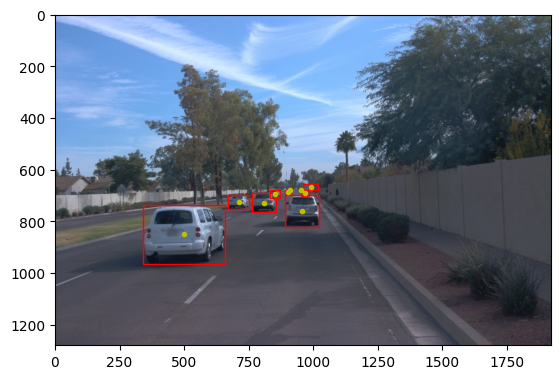

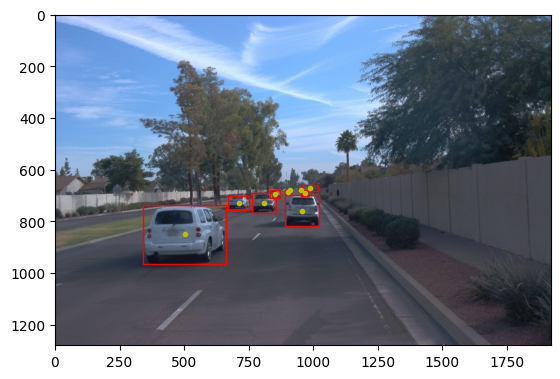

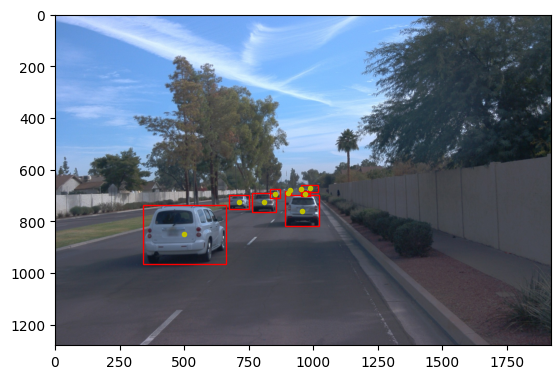

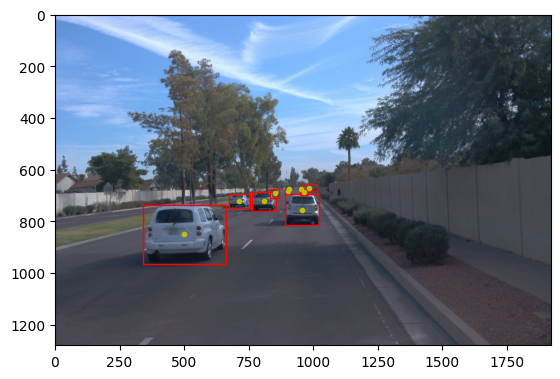

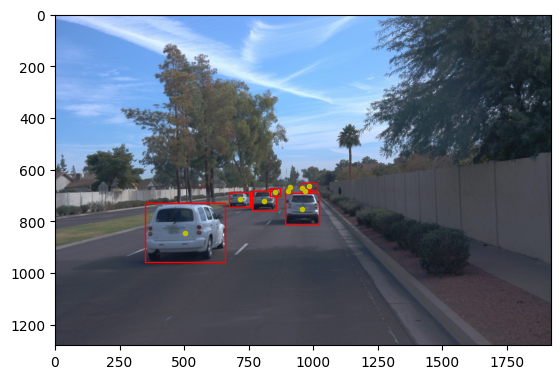

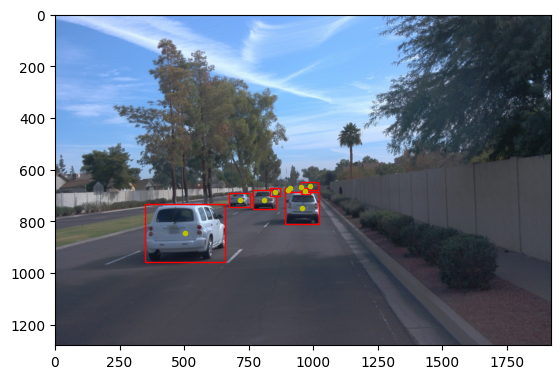

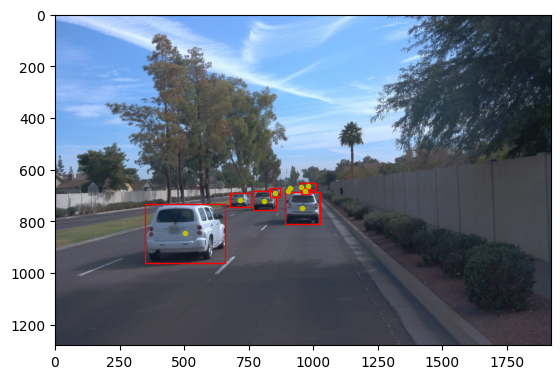

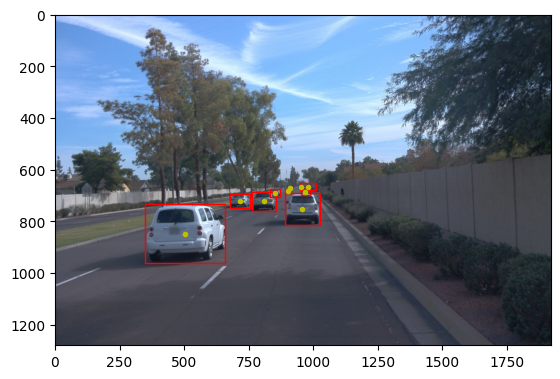

In [15]:
#extract information regarding 2D detections obtained from the camera

class Camera:
    '''Camera sensor class including field of view and coordinate transformation'''
    def __init__(self, camera_gt):
        self.fov = [-np.pi/4, np.pi/4] # sensor field of view / opening angle

        # coordiante transformation matrix from sensor to vehicle coordinates
        self.sens_to_veh = camera_gt.T           
        self.veh_to_sens = np.linalg.inv(self.sens_to_veh) # transformation vehicle to sensor coordinates
    
    def in_fov(self, x):
        # check if an object x can be seen by this sensor
        pos_veh = np.ones((4, x.shape[1])) # homogeneous coordinates
        pos_veh[0:3,:] = x[0:3,:] 
        pos_sens = self.veh_to_sens@pos_veh # transform from vehicle to sensor coordinates
        print(self.veh_to_sens)
        alpha = np.arctan(pos_sens[1]/pos_sens[0]) # calc angle between object and x-axis
        # no normalization needed because returned alpha always lies between [-pi/2, pi/2]
        return (alpha > self.fov[0]) & (alpha < self.fov[1])
        

for i in range(0,11):
    frame = dataset_tools.read_frame(f"../data_2/frame_{i}.pb")
    cam = frame.cameras[0]

    bounding_boxes = cam.detections
    
    plt.imshow(dataset_tools.decode_img(cam))
    for bounding_box in bounding_boxes:
        x0, y0, height, width = bounding_box.bbox
        plt.gca().add_patch(plt.Rectangle((x0-width/2, y0-height/2), width, height, fill=False, edgecolor='red', linewidth=1))
        # mark x0 and y0
        plt.plot(x0, y0, 'y.')
    plt.show()
    

#data from object detection
#with open('saved_dictionary.pkl', 'rb') as f:
#    loaded_dict = pickle.load(f)

 

# Kalman Filter extended

In [ ]:
class KalmanFilter:
    '''Kalman filter class'''
    def __init__(self, dim_state=1, 
                       dim_meas=1):

        self.x = np.zeros((dim_state, 1)) # state
        self.P = np.eye(dim_state) # uncertainty covariance
        self.Q = np.eye(dim_state) # process noise covariance
        self.F = np.eye(dim_state) # system matrix
        self.H = np.zeros((dim_meas, dim_state)) # measurement matrix
        self.R = np.eye(dim_meas)               # measurement uncertainty
        
    
    def predict(self, F = None, Q=None):
        
        if F is None:
            F = self.F
        if Q is None:
            Q = self.Q
        
        x = self.x
        P = self.P

        self.x = F@x # state prediction
        self.P = F@P@F.transpose() + Q # covariance prediction
        return self.x, self.P

    def update(self, z, R=None, H=None):
        # update state and covariance with associated measurement
        if H is None:
            H = self.H
        if R is None:
            R = self.R
        
        x = self.x
        P = self.P
        I = np.eye(x.shape[0])

        gamma = z - H@x # residual
        S = H@P@H.transpose() + R # covariance of residual
        K = P@H.transpose()@np.linalg.inv(S) # Kalman gain
        self.x = x + K@gamma # state update
        self.P = (I - K@H) @ P # covariance update
        return self.x, self.P     
    
np.random.seed(5)
N = 25
q = 1
dt = 1

pos_x = 0.0
pos_y = 0.0
pos_z = 0.0
vx = 1.0
vy = 1.0
vz = 1.0

x0 = np.array([[pos_x],
               [pos_y],
               [pos_z],
               [vx],
               [vy],
               [vz]])

kf = KalmanFilter(dim_state=6, dim_maes=3)
kf.x = x0
kf.F = np.array([[1, 0, 0, dt, 0, 0],
                 [0, 1, 0, 0, dt, 0],
                 [0, 0, 1, 0, 0, dt],
                 [0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1]])

kf.Q = np.array([[1, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1],])


kf.P = np.array([[1, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1],])

kf.H = np.array([[1,0,0],
                 [0,1,0],
                 [0,0,1]])

kf.R = np.array([[1,0,0],
                 [0,1,0],
                 [0,0,1]])

